In [1]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

D:\PythonProgm\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
original_dataset_dir = r'otters' 

base_dir = r'otters_data' 
if not os.path.isdir(base_dir): 
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.isdir(train_dir): 
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')  
if not os.path.isdir(validation_dir): 
    os.mkdir(validation_dir)
    
test_dir = os.path.join(base_dir, 'test')
if not os.path.isdir(test_dir): 
    os.mkdir(test_dir)

train_river_dir = os.path.join(train_dir, 'river')
if not os.path.isdir(train_river_dir): 
    os.mkdir(train_river_dir)
    
train_sea_dir = os.path.join(train_dir, 'sea')
if not os.path.isdir(train_sea_dir): 
    os.mkdir(train_sea_dir)
    
validation_river_dir = os.path.join(validation_dir, 'river')
if not os.path.isdir(validation_river_dir): 
    os.mkdir(validation_river_dir) 

validation_sea_dir = os.path.join(validation_dir, 'sea')
if not os.path.isdir(validation_sea_dir): 
    os.mkdir(validation_sea_dir)

test_river_dir = os.path.join(test_dir, 'river')
if not os.path.isdir(test_river_dir): 
    os.mkdir(test_river_dir)

test_sea_dir = os.path.join(test_dir, 'sea')
if not os.path.isdir(test_sea_dir): 
    os.mkdir(test_sea_dir)

In [ ]:
path_sea = os.path.join(original_dataset_dir, 'sea')
fnames   = os.listdir(path_sea)
for fname in fnames[0:100]:
    src = os.path.join(path_sea, fname)
    dst = os.path.join(train_sea_dir, fname)
    shutil.copyfile(src, dst)

for fname in fnames[100:200]:
    src = os.path.join(path_sea, fname)
    dst = os.path.join(validation_sea_dir, fname)
    shutil.copyfile(src, dst)

for fname in fnames[200:250]:
    src = os.path.join(path_sea, fname)
    dst = os.path.join(test_sea_dir, fname)
    shutil.copyfile(src, dst)
    
path_river = os.path.join(original_dataset_dir, 'river')
fnames     = os.listdir(path_river)
for fname in fnames[0:100]:
    src = os.path.join(path_river, fname)
    dst = os.path.join(validation_river_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in fnames[100:200]:
    src = os.path.join(path_river, fname)
    dst = os.path.join(train_river_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in fnames[200:250]:
    src = os.path.join(path_river, fname)
    dst = os.path.join(test_river_dir, fname)
    shutil.copyfile(src, dst)

In [86]:
print('Photos of sea otters in training process:', len(os.listdir(train_sea_dir)))
print('Photos of river otters in training process:', len(os.listdir(train_river_dir)))
print('Photos of sea otters in validation process:', len(os.listdir(validation_sea_dir)))
print('Photos of river otters in validation process:', len(os.listdir(validation_river_dir)))
print('Photos of sea otters in test process:', len(os.listdir(test_sea_dir)))
print('Photos of river otters in test process:', len(os.listdir(test_river_dir)))

Photos of sea otters in training process: 100
Photos of river otters in training process: 100
Photos of sea otters in validation process: 100
Photos of river otters in validation process: 100
Photos of sea otters in test process: 50
Photos of river otters in test process: 50


In [82]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Dropout consists in randomly setting a fraction rate of input units to 0 
# at each update during training time, which helps prevent overfitting.
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [83]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, )

# Do not generate of tensor image data via the ImageDataGenerator in validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,    
    target_size=(150, 150), 
    batch_size=10, # size of the batches of data
    class_mode='binary') #  binary: 1D numpy array of binary labels

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [84]:
from keras.callbacks import ReduceLROnPlateau
LR_function=ReduceLROnPlateau(monitor='val_acc',
                              # patience: number of epochs that produced the monitored quantity with no improvement 
                              # after which training will be stopped.
                              patience=3,                              
                              verbose=1,
                              factor=0.5, # factor by which the learning rate will be reduced
                              min_lr=0.00001 # lower bound on the learning rate
                              )

In [ ]:
# Start to train the model on data generated batch-by-batch by a Python generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 30, # steps_per_epoch * batch_size >= len(training data)
    epochs = 60,
    validation_data = validation_generator,
    # validation_steps: It should typically be equal to the number of samples of your validation 
    # dataset divided by the batch size.
    validation_steps = 10, # len(validation data) / batch size = 100 / 10 = 10
    callbacks=[LR_function])

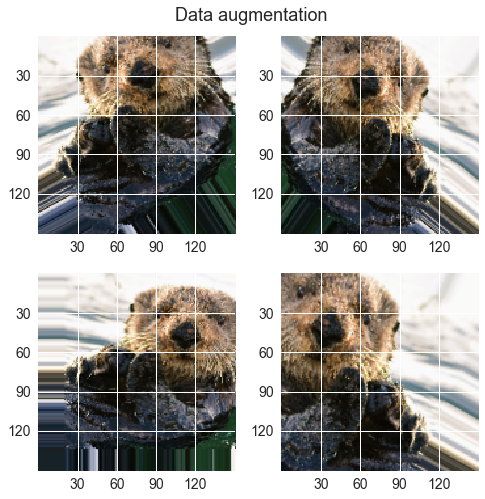

In [520]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from time import gmtime, strftime

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

fnames = [os.path.join(test_sea_dir, fname) for fname in os.listdir(test_sea_dir)]
img_path = fnames[11]

img = image.load_img(img_path, target_size=(151, 151))
x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)
i = 1

fig = plt.figure(num='otter',figsize=(8,8))


for batch in datagen.flow(x, batch_size=1):
    
    plt.subplot(2,2,i)    
    plt.imshow(image.array_to_img(batch[0]))
    plt.xticks(np.arange(30, 121, step = 30))
    plt.yticks(np.arange(30, 121, step = 30))
    plt.grid(True)
    i += 1
    if i % 5 == 0:
        break

fig.suptitle("Data augmentation", fontsize = 18, y = 0.93)

now = strftime("%Y%m%d%H%M%S")
plt.savefig('otter_newImg' + '_' + now + '.jpg', dpi= 400)
plt.show()

In [93]:
#Save the model
model.save_weights('CNN_otters_wieghts.h5')
model.save('CNN_otters.h5')

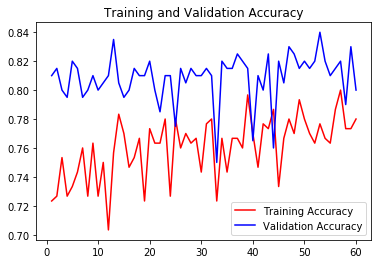

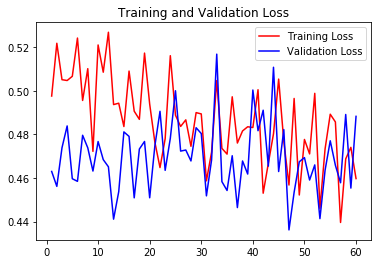

In [94]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_acc,'b-',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [125]:
# Loading model
from keras.models import load_model
model_load  = load_model('CNN_otters.h5')
model_load.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [311]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator.reset()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 1,
    shuffle = False, # if set to False, sorts the data in alphanumeric order
    class_mode = None) # only data, no labels

Found 94 images belonging to 2 classes.


In [312]:
prediction = model_load.predict_generator(test_generator,
                                          steps = len(test_generator),                                          
                                          verbose = 1)
predict_label = []
tempL = prediction.tolist()
for ii in range(0, len(tempL)):    
    predict_label.append(tempL[ii][0])
    
predict_label =  [1 if i >= 0.5 else 0 for i in predict_label]
predict_label = np.array(predict_label)
print("predict_label:")
print(predict_label)

true_label = test_generator.classes
print("true_label:")
print(true_label)

94/94 [==============================] - 6s 69ms/step
predict_label:
[1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
true_label:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [306]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(true_label, predict_label))
print('------------------------')
print('Classification Report')
target_names = ['River', 'Sea']
print(classification_report(true_label, 
                            predict_label, 
                            target_names=target_names))

Confusion Matrix
[[34 13]
 [ 4 43]]
------------------------
Classification Report
             precision    recall  f1-score   support

      River       0.89      0.72      0.80        47
        Sea       0.77      0.91      0.83        47

avg / total       0.83      0.82      0.82        94



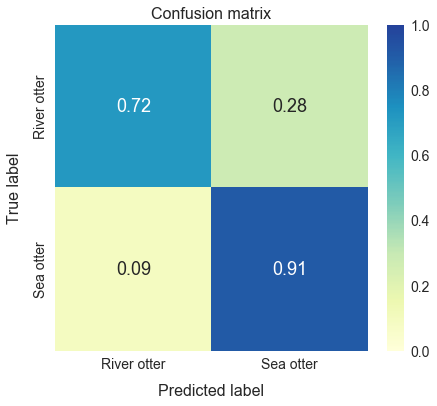

In [433]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(true_label, predict_label)
array = array / array.astype(np.float).sum(axis=1)
df_cm = pd.DataFrame(array, range(2), range(2))
df_cm = df_cm.round(2)
tickList = ["River otter", "Sea otter"]
df_cm.index   = tickList
df_cm.columns = tickList

plt.figure(figsize = (7, 6))
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, 
                annot=True, 
                annot_kws={"size": 18}, # font size
                vmin=0, 
                vmax=1,
                cmap="YlGnBu",
                center = 0.6)

plt.yticks(np.arange(len(tickList)) + 0.5,
                     tickList, 
                     rotation=90, 
                     fontsize="14", 
                     va="center")

plt.title("Confusion matrix", fontsize = 16)
plt.xlabel("Predicted label", fontsize = 16,  labelpad = 12)
plt.ylabel("True label", fontsize = 16,  labelpad = 12)
plt.savefig('Confusion_matrix.jpg', dpi= 400)
plt.show()

In [322]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
predList = []
classNames = ["river", "sea"]

for className in classNames:
    img_Fidpath = r'otters_data\test\\'
    img_Fidpath += className

    fnames   = os.listdir(img_Fidpath)

    for ii in range(0, len(fnames)):    
        img_path = img_Fidpath + "\\" + fnames[ii]
        img = image.load_img(img_path, target_size = (150, 150))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis = 0)
        img_tensor /= 255.
        preds = model.predict(img_tensor)
        predList.append(preds[0][0])
        
# river otter (label = 0) / sea otter (label = 1)
predList_new =  [1 if i >= 0.5 else 0 for i in predList]    
predList_new = np.array(predList_new)
predList_new
print("predict_label:")
print(predList_new)
# img_tensor.shape
# plt.imshow(img_tensor[0])
# plt.show()

predict_label:
[1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [323]:
# Check
predict_label - predList_new

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Tensor("conv2d_9_2/Relu:0", shape=(?, 148, 148, 32), dtype=float32)
Tensor("max_pooling2d_9_2/MaxPool:0", shape=(?, 74, 74, 32), dtype=float32)
Tensor("conv2d_10_2/Relu:0", shape=(?, 72, 72, 64), dtype=float32)
Tensor("max_pooling2d_10_2/MaxPool:0", shape=(?, 36, 36, 64), dtype=float32)
Tensor("conv2d_11_2/Relu:0", shape=(?, 34, 34, 128), dtype=float32)
Tensor("max_pooling2d_11_2/MaxPool:0", shape=(?, 17, 17, 128), dtype=float32)
Tensor("conv2d_12_2/Relu:0", shape=(?, 15, 15, 128), dtype=float32)
Tensor("max_pooling2d_12_2/MaxPool:0", shape=(?, 7, 7, 128), dtype=float32)
8
(1, 148, 148, 32)


D:\PythonProgm\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


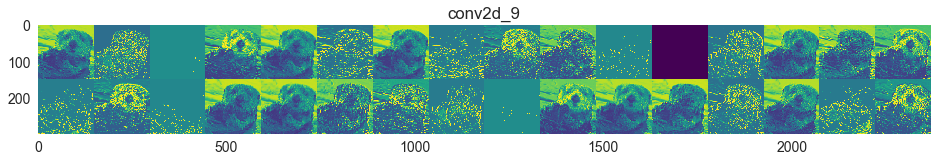

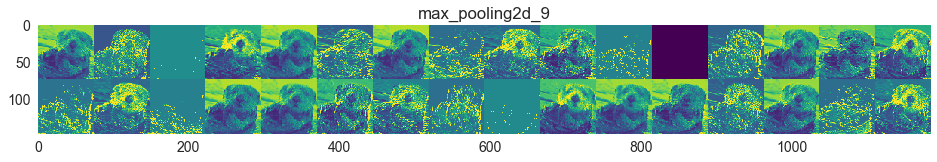

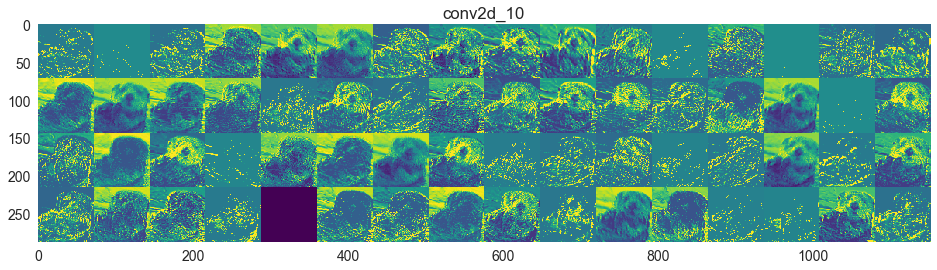

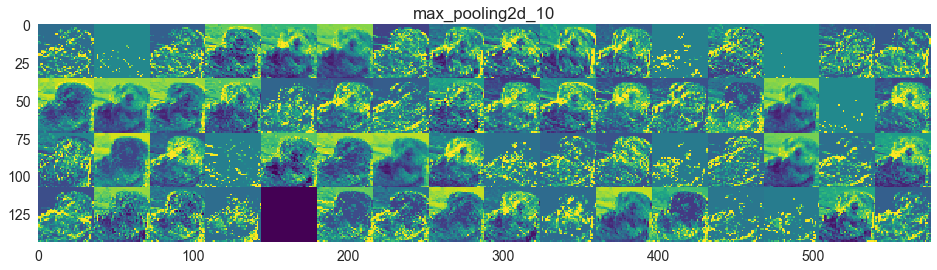

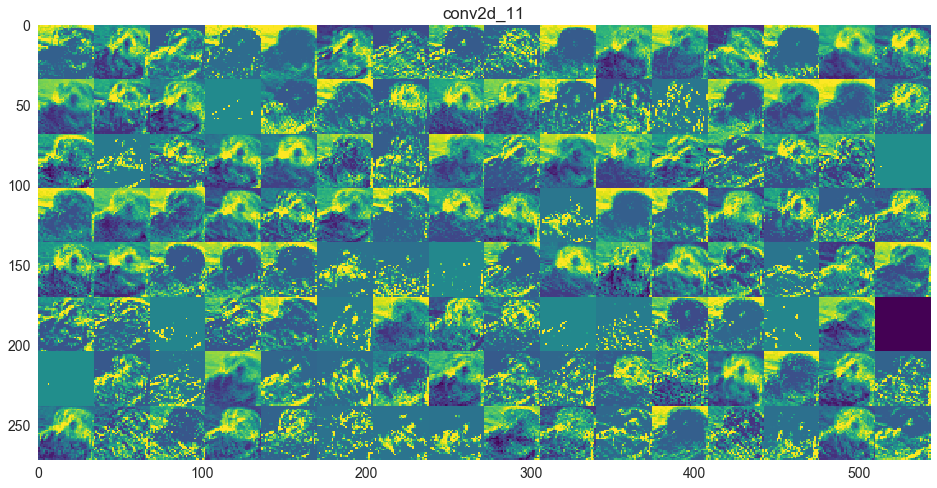

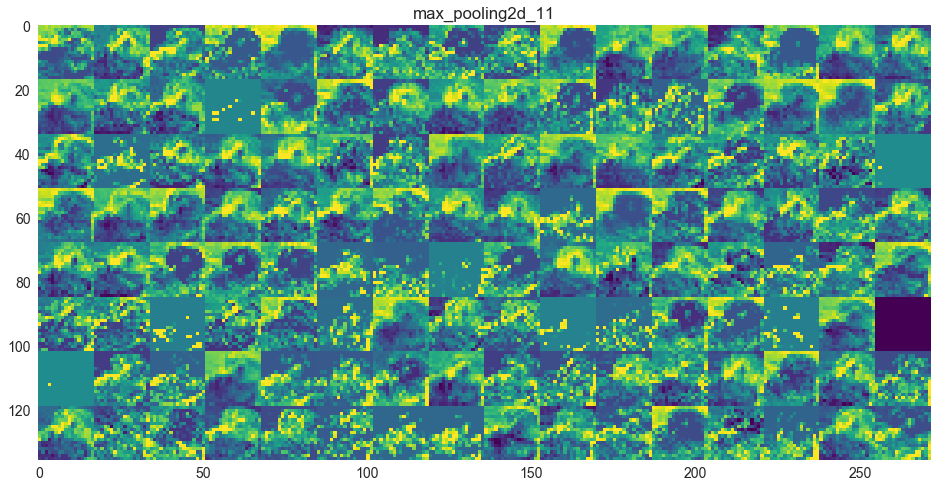

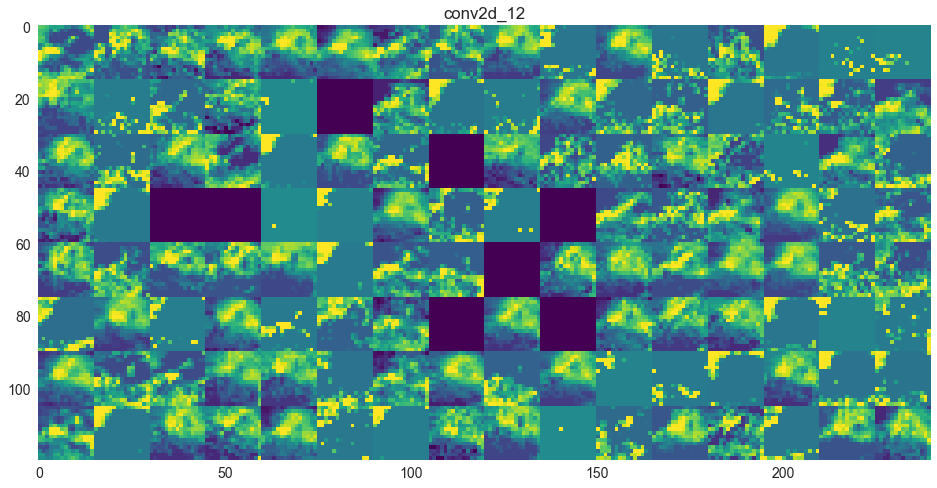

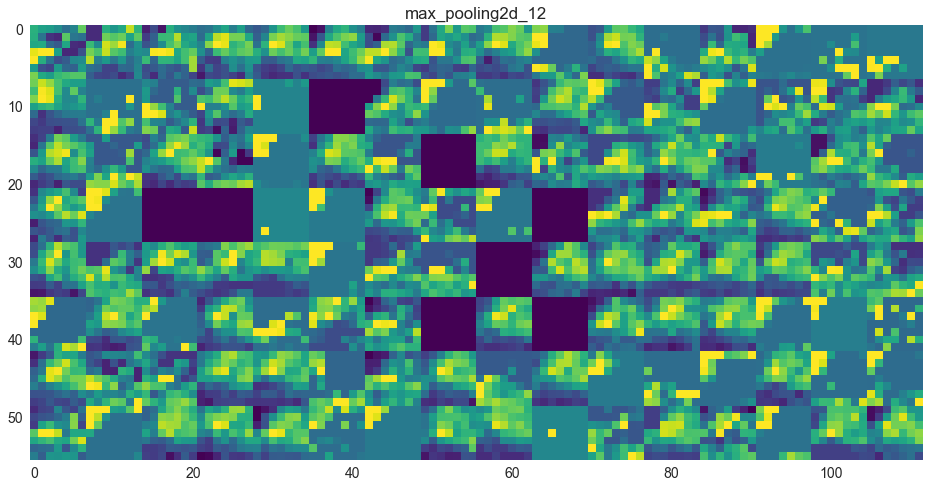

In [521]:
from keras import models 
layer_outputs = [layer.output for layer in model_load.layers[:8]]
for op in layer_outputs: 
    print(op)

activation_model = models.Model(inputs=model_load.input, outputs=layer_outputs)
layer_names = []


classNames = ["river", "sea"]
img_Fidpath = r"C:\Users\gtra389\15_CNN\otters_data\test"
img_Fidpath += "\\"
img_Fidpath += classNames[1]

fnames   = os.listdir(img_Fidpath)
img_path = img_Fidpath + "\\" + fnames[11]
img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

activations = activation_model.predict(img_tensor)
print(len(activations))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')